# Surrogate-Primed KV Caching: Answer Quality Evaluation

## Real-World Motivation: Ads & Search Systems

In large-scale systems like ad serving or document search, we face an asymmetric compute problem:

| Phase | Timing | Compute Budget | What We Know |
|-------|--------|----------------|---------------|
| **Indexing** | Offline | Expensive OK | Documents only |
| **Query** | Online | Must be fast | User query arrives |

**The Opportunity**: Pre-compute KV caches for documents at indexing time, then reuse them at query time.

**The Problem**: A KV cache built from just the document may not be optimally "oriented" for answering user queries.

**The Hypothesis**: If we generate a *surrogate query* from the document at indexing time and include it in the context when building the KV cache, the resulting cache will be more "query-ready" and produce better answers when the actual query arrives.

## Why This Might Work

The KV cache stores key-value representations that new tokens will attend to. When we process a document with query context, the model's representations may:

1. **Emphasize query-relevant information** - Attention patterns during caching focus on answerable content
2. **Encode task context** - The model "knows" it should be ready to answer questions
3. **Align representations** - Document representations are oriented toward the query space

## Experimental Design

```
┌─────────────────────────────────────────────────────────────────┐
│  PHASE 1: INDEXING TIME (Simulated)                            │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  For each document:                                             │
│                                                                 │
│  Baseline Cache:                                                │
│    Build KV from: "Document: [doc]"                            │
│                                                                 │
│  Surrogate-Primed Cache:                                        │
│    1. Generate surrogate query from document (no real query!)   │
│    2. Build KV from: "Relevant query: [surrogate]               │
│                       Document: [doc]"                          │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│  PHASE 2: QUERY TIME (Simulated)                               │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  For each (document, actual_query, reference_answer):          │
│                                                                 │
│  1. Extend the cached KV with: "Query: [actual_query]           │
│                                 Answer:"                        │
│                                                                 │
│  2. Measure: NLL of [reference_answer]                          │
│     OR Generate answer and evaluate quality                     │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│  METRIC                                                        │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  Primary: NLL of reference answer (lower = better)              │
│                                                                 │
│  Delta = NLL(answer|baseline) - NLL(answer|surrogate)          │
│  Positive Delta = Surrogate-primed cache is BETTER             │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

## Key Design Decisions

1. **Surrogate is a hint, not a query to answer**: The surrogate appears as context ("Relevant query: ...") not as a question requiring an answer. This primes the cache without creating confusion about which query to answer.

2. **Same query for both conditions**: At query time, both caches receive the identical actual query. Only the cached document representation differs.

3. **Answer quality, not query prediction**: We measure how well the model can answer the query, which is the actual downstream task.

4. **Surrogate never sees ground truth**: The surrogate is generated from the document alone, simulating true indexing-time conditions.

## Step 1: Setup & Configuration

In [1]:
# Install dependencies
!pip install transformers torch datasets tqdm scipy bitsandbytes accelerate matplotlib sentence-transformers -q

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import json
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# For surrogate quality measurement
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
@dataclass
class ExperimentConfig:
    """
    Configuration for the Surrogate-Primed KV Caching experiment.
    
    This experiment tests whether pre-computing KV caches with surrogate
    query context improves answer quality at query time.
    """
    
    # Model settings
    model_name: str = "mistralai/Mistral-7B-Instruct-v0.2"
    use_4bit: bool = True  # Quantization for memory efficiency
    
    # Dataset settings
    dataset_name: str = "ms_marco"
    dataset_config: str = "v1.1"
    dataset_split: str = "validation"
    num_samples: int = 1000
    min_passage_words: int = 50
    max_passage_words: int = 200
    
    # Surrogate generation settings
    surrogate_temperature: float = 0.0  # Deterministic
    surrogate_max_tokens: int = 30
    surrogate_generation_prompt: str = (
        "Read the following text and write ONE short search query (3-8 words) "
        "that someone would type into Google to find this text. "
        "Output only the query with no quotes, alternatives, or explanation."
    )
    
    # === CRITICAL: Context templates for KV cache building ===
    # These define what goes into the KV cache at "indexing time"
    
    # Baseline: Just the document (no query context)
    baseline_cache_template: str = "Document:\n{document}"
    
    # Surrogate-primed: Document with surrogate query as context hint
    # The surrogate is presented as a "hint" about what queries might come,
    # NOT as a query to be answered
    surrogate_cache_template: str = (
        "This document may be relevant to queries like: {surrogate}\n\n"
        "Document:\n{document}"
    )
    
    # === Query-time template (appended to cached context) ===
    query_template: str = "\n\nQuery: {query}\n\nAnswer:"
    
    # Answer generation settings (for generating reference answers)
    answer_max_tokens: int = 100
    answer_temperature: float = 0.0
    
    # Embedding model for similarity measurement
    embedding_model_name: str = "all-MiniLM-L6-v2"
    
    # Random seed
    seed: int = 42
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


config = ExperimentConfig()
print(f"Device: {config.device}")
print(f"Model: {config.model_name}")
print(f"\nBaseline cache template:")
print(f"  {config.baseline_cache_template[:50]}...")
print(f"\nSurrogate cache template:")
print(f"  {config.surrogate_cache_template[:60]}...")

Device: cuda
Model: mistralai/Mistral-7B-Instruct-v0.2

Baseline cache template:
  Document:
{document}...

Surrogate cache template:
  This document may be relevant to queries like: {surrogate}

...


In [4]:
# Set random seeds
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Load model and tokenizer
print("Loading model and tokenizer...")

if config.use_4bit:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        quantization_config=quantization_config,
        device_map="auto",
        trust_remote_code=True,
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )

tokenizer = AutoTokenizer.from_pretrained(config.model_name, trust_remote_code=True)
tokenizer.padding_side = "right"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.eval()
print(f"Model loaded: {model.num_parameters():,} parameters")

# Load embedding model for similarity measurement
print(f"\nLoading embedding model: {config.embedding_model_name}")
embed_model = SentenceTransformer(config.embedding_model_name)
print("Embedding model loaded.")

Loading model and tokenizer...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded: 7,241,732,096 parameters

Loading embedding model: all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded.


## Step 2: Load Dataset

We use MS MARCO, which contains:
- **Passages**: Documents/ads that we want to cache
- **Queries**: User queries that arrive at "query time"
- **Answers**: Reference answers for evaluation (when available)

This closely mirrors the ads/search use case:
- Passages = Ads or web pages
- Queries = User search queries
- Answers = What we want the system to produce

In [5]:
def count_words(text: str) -> int:
    return len(text.split())


def load_and_filter_dataset(config: ExperimentConfig) -> List[Dict]:
    """
    Load MS MARCO dataset and filter for samples with answers.
    
    Returns list of dicts with 'passage', 'query', and 'answer' keys.
    """
    print(f"Loading {config.dataset_name} dataset...")
    
    dataset = load_dataset(
        config.dataset_name,
        config.dataset_config,
        split=config.dataset_split,
    )
    
    print(f"Total samples: {len(dataset)}")
    
    filtered_samples = []
    
    for item in tqdm(dataset, desc="Filtering samples"):
        passages = item.get('passages', {})
        passage_texts = passages.get('passage_text', [])
        is_selected = passages.get('is_selected', [])
        
        query = item.get('query', '')
        answers = item.get('answers', [])
        
        # Skip if no passages, query, or answers
        if not passage_texts or not query:
            continue
        
        # Get the best answer (prefer wellFormedAnswers if available)
        well_formed = item.get('wellFormedAnswers', [])
        if well_formed and len(well_formed) > 0 and well_formed[0] != '[]':
            answer = well_formed[0]
        elif answers and len(answers) > 0 and answers[0] != 'No Answer Present.':
            answer = answers[0]
        else:
            continue  # Skip samples without answers
        
        # Find a good passage
        for i, passage in enumerate(passage_texts):
            word_count = count_words(passage)
            if config.min_passage_words <= word_count <= config.max_passage_words:
                # Prefer selected passages
                if is_selected and i < len(is_selected) and is_selected[i] == 1:
                    filtered_samples.append({
                        'passage': passage,
                        'query': query,
                        'answer': answer
                    })
                    break
        
        if len(filtered_samples) >= config.num_samples * 2:
            break
    
    # Shuffle and select
    np.random.shuffle(filtered_samples)
    filtered_samples = filtered_samples[:config.num_samples]
    
    print(f"Selected {len(filtered_samples)} samples with answers")
    return filtered_samples

In [6]:
# Load dataset
samples = load_and_filter_dataset(config)

# Preview a sample
print("\n" + "="*80)
print("SAMPLE PREVIEW")
print("="*80)
print(f"\nPassage ({count_words(samples[0]['passage'])} words):")
print(samples[0]['passage'][:300] + "...")
print(f"\nQuery: {samples[0]['query']}")
print(f"\nReference Answer: {samples[0]['answer']}")

Loading ms_marco dataset...
Total samples: 10047


Filtering samples:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 1000 samples with answers

SAMPLE PREVIEW

Passage (86 words):
• Almonds. Almonds contain more calcium than any other nut, and they are also good sources of fiber, folic acid, magnesium, potassium and protein. Incredibly versatile for both savory and sweet dishes, almonds lend a rich flavor and dimension to a variety of recipes. To make up for the calcium found...

Query: what foods other than dairy products contain calcium

Reference Answer: 1 Spinach. 2 Kale. 3 Okra. 4 Collards. 5 Soybeans. 6 White beans. 7 Some fish like sardines, salmon, perch, rainbow trout and 8 Almonds.


## Step 3: Surrogate Query Generation

At "indexing time", we generate a surrogate query from the document alone.

**Critical constraint**: The surrogate generator NEVER sees the actual query or answer. This simulates the real production setting where we don't know user queries ahead of time.

In [7]:
def generate_surrogate(
    doc_text: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> str:
    """
    Generate a surrogate query from a document.
    
    This simulates "indexing time" - we only have the document,
    not the actual user query that will arrive later.
    """
    messages = [
        {
            "role": "user",
            "content": f"{config.surrogate_generation_prompt}\n\nText:\n{doc_text}"
        }
    ]
    
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    inputs = tokenizer(prompt, return_tensors="pt").to(config.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=config.surrogate_max_tokens,
            temperature=config.surrogate_temperature if config.surrogate_temperature > 0 else None,
            do_sample=config.surrogate_temperature > 0,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    surrogate = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    
    # Clean up
    surrogate = surrogate.strip('"\'')
    surrogate = surrogate.split('\n')[0].strip()
    
    return surrogate


def compute_similarity(text1: str, text2: str, embed_model: SentenceTransformer) -> float:
    """Compute semantic similarity between two texts."""
    embeddings = embed_model.encode([text1, text2])
    return float(cosine_similarity([embeddings[0]], [embeddings[1]])[0][0])

In [8]:
# Test surrogate generation
print("Testing surrogate generation...")
test_surrogate = generate_surrogate(samples[0]['passage'], model, tokenizer, config)
test_similarity = compute_similarity(test_surrogate, samples[0]['query'], embed_model)

print(f"\nDocument: {samples[0]['passage'][:150]}...")
print(f"\nGenerated Surrogate: '{test_surrogate}'")
print(f"Actual Query: '{samples[0]['query']}'")
print(f"Similarity: {test_similarity:.4f}")

Testing surrogate generation...

Document: • Almonds. Almonds contain more calcium than any other nut, and they are also good sources of fiber, folic acid, magnesium, potassium and protein. Inc...

Generated Surrogate: 'Almonds high calcium sources"'
Actual Query: 'what foods other than dairy products contain calcium'
Similarity: 0.6323


## Step 4: KV Cache Surgery - The Core Experiment

This is where the magic happens. We implement the two-phase caching approach:

### Phase 1: Build KV Cache (Indexing Time)
- **Baseline**: Cache from `"Document: [doc]"`
- **Surrogate**: Cache from `"Relevant query: [surrogate]\nDocument: [doc]"`

### Phase 2: Extend Cache & Score Answer (Query Time)
- Extend both caches with `"Query: [actual_query]\nAnswer:"`
- Measure NLL of the reference answer

Lower NLL = The model finds the answer more "natural" given the context = Better cache

In [9]:
def build_kv_cache(
    context: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> Tuple[torch.Tensor, any]:
    """
    Build a KV cache from the given context.
    
    This simulates the "indexing time" computation that would be
    done offline for each document/ad.
    
    Returns:
        Tuple of (context_ids, past_key_values)
    """
    context_encoding = tokenizer(
        context,
        return_tensors="pt",
        add_special_tokens=True,
        padding=False,
        truncation=False
    )
    context_ids = context_encoding['input_ids'].to(config.device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=context_ids,
            attention_mask=torch.ones_like(context_ids),
            use_cache=True,
            return_dict=True
        )
    
    return context_ids, outputs.past_key_values


def score_answer_with_cache(
    past_key_values: any,
    context_len: int,
    query_and_answer_prompt: str,
    answer: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> Tuple[float, int]:
    """
    Score an answer using a pre-built KV cache.
    
    This simulates "query time":
    1. The actual query arrives
    2. We extend the cached context with the query
    3. We measure how well the cache supports generating the answer
    
    Args:
        past_key_values: Pre-computed KV cache from indexing time
        context_len: Length of the cached context
        query_and_answer_prompt: "Query: [q]\nAnswer:" to append
        answer: The reference answer to score
        model, tokenizer, config: Standard args
    
    Returns:
        Tuple of (mean_nll, num_tokens_scored)
    """
    # Tokenize the query prompt (no special tokens - continues from cache)
    query_encoding = tokenizer(
        query_and_answer_prompt,
        return_tensors="pt",
        add_special_tokens=False,
        padding=False,
        truncation=False
    )
    query_ids = query_encoding['input_ids'].to(config.device)
    query_len = query_ids.shape[1]
    
    # Tokenize the answer (no special tokens)
    answer_encoding = tokenizer(
        answer,
        return_tensors="pt",
        add_special_tokens=False,
        padding=False,
        truncation=False
    )
    answer_ids = answer_encoding['input_ids'].to(config.device)
    answer_len = answer_ids.shape[1]
    
    # === PHASE 2A: Extend cache with query ===
    # Process the query using the cached KV states
    combined_len_after_query = context_len + query_len
    attention_mask_query = torch.ones((1, combined_len_after_query), device=config.device)
    
    with torch.no_grad():
        query_outputs = model(
            input_ids=query_ids,
            attention_mask=attention_mask_query,
            past_key_values=past_key_values,
            use_cache=True,
            return_dict=True
        )
        extended_cache = query_outputs.past_key_values
    
    # === PHASE 2B: Score the answer ===
    # Process answer tokens using the extended cache
    combined_len_final = context_len + query_len + answer_len
    attention_mask_answer = torch.ones((1, combined_len_final), device=config.device)
    
    with torch.no_grad():
        answer_outputs = model(
            input_ids=answer_ids,
            attention_mask=attention_mask_answer,
            past_key_values=extended_cache,
            use_cache=False,
            return_dict=True
        )
    
    # Compute NLL on answer tokens
    logits = answer_outputs.logits  # (1, answer_len, vocab)
    
    # Shift for autoregressive loss
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = answer_ids[:, 1:].contiguous()
    
    shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    shift_labels = shift_labels.view(-1)
    
    loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
    nll = loss_fct(shift_logits, shift_labels).item()
    
    num_scored = answer_len - 1
    mean_nll = nll / num_scored if num_scored > 0 else 0.0
    
    return mean_nll, num_scored

In [10]:
def evaluate_sample(
    passage: str,
    query: str,
    answer: str,
    surrogate: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> Dict:
    """
    Evaluate a single sample with both baseline and surrogate caches.
    
    This is the core comparison:
    - Baseline: Cache from document only
    - Surrogate: Cache from surrogate + document
    
    Both are then used to score the same (query, answer) pair.
    """
    # === INDEXING TIME: Build caches ===
    
    # Baseline cache (document only)
    baseline_context = config.baseline_cache_template.format(document=passage)
    baseline_ids, baseline_cache = build_kv_cache(
        baseline_context, model, tokenizer, config
    )
    baseline_context_len = baseline_ids.shape[1]
    
    # Surrogate-primed cache
    surrogate_context = config.surrogate_cache_template.format(
        surrogate=surrogate, document=passage
    )
    surrogate_ids, surrogate_cache = build_kv_cache(
        surrogate_context, model, tokenizer, config
    )
    surrogate_context_len = surrogate_ids.shape[1]
    
    # === QUERY TIME: Score answer with each cache ===
    
    query_prompt = config.query_template.format(query=query)
    
    # Score with baseline cache
    baseline_nll, num_tokens = score_answer_with_cache(
        baseline_cache, baseline_context_len,
        query_prompt, answer,
        model, tokenizer, config
    )
    
    # Score with surrogate cache
    surrogate_nll, _ = score_answer_with_cache(
        surrogate_cache, surrogate_context_len,
        query_prompt, answer,
        model, tokenizer, config
    )
    
    # Delta: positive means surrogate is better (lower NLL)
    delta = baseline_nll - surrogate_nll
    
    return {
        'baseline_nll': baseline_nll,
        'surrogate_nll': surrogate_nll,
        'delta': delta,
        'num_answer_tokens': num_tokens,
        'baseline_context_len': baseline_context_len,
        'surrogate_context_len': surrogate_context_len,
    }

In [11]:
# Test the evaluation on a single sample
print("Testing evaluation pipeline...")
print("="*60)

test_sample = samples[0]
test_surrogate = generate_surrogate(test_sample['passage'], model, tokenizer, config)

print(f"Query: {test_sample['query']}")
print(f"Surrogate: {test_surrogate}")
print(f"Answer: {test_sample['answer'][:100]}...")

test_result = evaluate_sample(
    test_sample['passage'],
    test_sample['query'],
    test_sample['answer'],
    test_surrogate,
    model, tokenizer, config
)

print(f"\n{'='*60}")
print("RESULTS")
print(f"{'='*60}")
print(f"Baseline NLL:  {test_result['baseline_nll']:.4f}")
print(f"Surrogate NLL: {test_result['surrogate_nll']:.4f}")
print(f"Delta:         {test_result['delta']:.4f} ({'Surrogate WINS' if test_result['delta'] > 0 else 'Baseline WINS'})")
print(f"\nContext lengths: Baseline={test_result['baseline_context_len']}, Surrogate={test_result['surrogate_context_len']}")

Testing evaluation pipeline...
Query: what foods other than dairy products contain calcium
Surrogate: Almonds high calcium sources"
Answer: 1 Spinach. 2 Kale. 3 Okra. 4 Collards. 5 Soybeans. 6 White beans. 7 Some fish like sardines, salmon,...

RESULTS
Baseline NLL:  2.1053
Surrogate NLL: 1.9912
Delta:         0.1140 (Surrogate WINS)

Context lengths: Baseline=139, Surrogate=158


## Step 5: Run Full Experiment

In [12]:
def run_experiment(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig
) -> List[Dict]:
    """
    Run the full experiment across all samples.
    
    For each sample:
    1. Generate surrogate from document (indexing time)
    2. Build baseline and surrogate caches (indexing time)
    3. Score answer with both caches (query time)
    4. Record results
    """
    results = []
    
    for i, sample in enumerate(tqdm(samples, desc="Running experiment")):
        try:
            passage = sample['passage']
            query = sample['query']
            answer = sample['answer']
            
            # Generate surrogate (indexing time - no access to query)
            surrogate = generate_surrogate(passage, model, tokenizer, config)
            
            # Compute surrogate quality
            surrogate_similarity = compute_similarity(surrogate, query, embed_model)
            
            # Evaluate with both caches
            eval_result = evaluate_sample(
                passage, query, answer, surrogate,
                model, tokenizer, config
            )
            
            results.append({
                'sample_idx': i,
                'query': query,
                'surrogate': surrogate,
                'answer_preview': answer[:50] + '...' if len(answer) > 50 else answer,
                'surrogate_similarity': surrogate_similarity,
                **eval_result
            })
            
        except Exception as e:
            print(f"\nError on sample {i}: {e}")
            continue
        
        if i % 20 == 0:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return results

In [13]:
# Run the experiment
print(f"Running experiment on {len(samples)} samples...")
print("="*80)

results = run_experiment(samples, model, tokenizer, embed_model, config)

print(f"\nCompleted {len(results)} samples successfully")

Running experiment on 1000 samples...


Running experiment:   0%|          | 0/1000 [00:00<?, ?it/s]


Completed 1000 samples successfully


## Step 6: Analysis

In [14]:
def analyze_results(results: List[Dict]) -> Dict:
    """
    Compute comprehensive statistics on the experiment results.
    """
    baseline_nlls = np.array([r['baseline_nll'] for r in results])
    surrogate_nlls = np.array([r['surrogate_nll'] for r in results])
    deltas = np.array([r['delta'] for r in results])
    similarities = np.array([r['surrogate_similarity'] for r in results])
    
    # Win rate (surrogate better = positive delta)
    wins = np.sum(deltas > 0)
    
    # Statistical tests
    t_stat, p_value = stats.ttest_rel(baseline_nlls, surrogate_nlls)
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(baseline_nlls, surrogate_nlls)
    
    # Effect size
    diff = baseline_nlls - surrogate_nlls
    cohens_d = np.mean(diff) / np.std(diff, ddof=1) if np.std(diff) > 0 else 0
    
    # Correlation between surrogate quality and improvement
    corr, corr_p = stats.pearsonr(similarities, deltas)
    
    return {
        'n_samples': len(results),
        'mean_baseline_nll': np.mean(baseline_nlls),
        'mean_surrogate_nll': np.mean(surrogate_nlls),
        'std_baseline_nll': np.std(baseline_nlls),
        'std_surrogate_nll': np.std(surrogate_nlls),
        'wins': int(wins),
        'win_rate': wins / len(results),
        'mean_delta': np.mean(deltas),
        'std_delta': np.std(deltas),
        'median_delta': np.median(deltas),
        't_statistic': t_stat,
        'p_value': p_value,
        'wilcoxon_p': wilcoxon_p,
        'cohens_d': cohens_d,
        'mean_similarity': np.mean(similarities),
        'correlation_similarity_delta': corr,
        'correlation_p_value': corr_p,
    }

In [15]:
# Analyze results
analysis = analyze_results(results)

print("="*80)
print("EXPERIMENT RESULTS: ANSWER QUALITY EVALUATION")
print("="*80)
print(f"\nSamples analyzed: {analysis['n_samples']}")

print(f"\n{'='*80}")
print("ANSWER NLL BY CONDITION (lower = better answer quality)")
print(f"{'='*80}")
print(f"{'Condition':<25} {'Mean NLL':>12} {'Std':>10}")
print(f"{'-'*47}")
print(f"{'Baseline (doc only)':<25} {analysis['mean_baseline_nll']:>12.4f} {analysis['std_baseline_nll']:>10.4f}")
print(f"{'Surrogate-primed':<25} {analysis['mean_surrogate_nll']:>12.4f} {analysis['std_surrogate_nll']:>10.4f}")

print(f"\n{'='*80}")
print("WIN/LOSS ANALYSIS")
print(f"{'='*80}")
print(f"Surrogate Wins: {analysis['wins']}/{analysis['n_samples']} ({analysis['win_rate']*100:.1f}%)")
print(f"Baseline Wins:  {analysis['n_samples'] - analysis['wins']}/{analysis['n_samples']} ({(1-analysis['win_rate'])*100:.1f}%)")

print(f"\n{'='*80}")
print("DELTA STATISTICS (positive = surrogate better)")
print(f"{'='*80}")
print(f"Mean Delta:   {analysis['mean_delta']:.4f}")
print(f"Median Delta: {analysis['median_delta']:.4f}")
print(f"Std Delta:    {analysis['std_delta']:.4f}")

print(f"\n{'='*80}")
print("STATISTICAL SIGNIFICANCE")
print(f"{'='*80}")
print(f"Paired t-test: t={analysis['t_statistic']:.4f}, p={analysis['p_value']:.6f}")
print(f"Wilcoxon test: p={analysis['wilcoxon_p']:.6f}")
print(f"Cohen's d (effect size): {analysis['cohens_d']:.4f}")

print(f"\n{'='*80}")
print("SURROGATE QUALITY ANALYSIS")
print(f"{'='*80}")
print(f"Mean surrogate-query similarity: {analysis['mean_similarity']:.4f}")
print(f"Correlation (similarity vs delta): r={analysis['correlation_similarity_delta']:.4f}, p={analysis['correlation_p_value']:.6f}")

# Interpretation
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")

if analysis['p_value'] < 0.05:
    if analysis['mean_delta'] > 0:
        print("RESULT: Surrogate-primed caching SIGNIFICANTLY IMPROVES answer quality!")
        print(f"        The surrogate cache produces answers with {abs(analysis['mean_delta']):.4f} lower NLL on average.")
    else:
        print("RESULT: Surrogate-primed caching SIGNIFICANTLY HURTS answer quality.")
        print(f"        The baseline cache produces answers with {abs(analysis['mean_delta']):.4f} lower NLL on average.")
else:
    print("RESULT: No statistically significant difference between conditions.")

if analysis['correlation_p_value'] < 0.05:
    if analysis['correlation_similarity_delta'] > 0:
        print(f"\nIMPORTANT: Better surrogates lead to better results (r={analysis['correlation_similarity_delta']:.3f})")
    else:
        print(f"\nSurprising: Better surrogates don't help (r={analysis['correlation_similarity_delta']:.3f})")

EXPERIMENT RESULTS: ANSWER QUALITY EVALUATION

Samples analyzed: 1000

ANSWER NLL BY CONDITION (lower = better answer quality)
Condition                     Mean NLL        Std
-----------------------------------------------
Baseline (doc only)             1.3868     2.0557
Surrogate-primed                1.1281     1.6082

WIN/LOSS ANALYSIS
Surrogate Wins: 715/1000 (71.5%)
Baseline Wins:  285/1000 (28.5%)

DELTA STATISTICS (positive = surrogate better)
Mean Delta:   0.2587
Median Delta: 0.1167
Std Delta:    0.6377

STATISTICAL SIGNIFICANCE
Paired t-test: t=12.8224, p=0.000000
Wilcoxon test: p=0.000000
Cohen's d (effect size): 0.4055

SURROGATE QUALITY ANALYSIS
Mean surrogate-query similarity: 0.6672
Correlation (similarity vs delta): r=-0.0311, p=0.325399

CONCLUSION
RESULT: Surrogate-primed caching SIGNIFICANTLY IMPROVES answer quality!
        The surrogate cache produces answers with 0.2587 lower NLL on average.


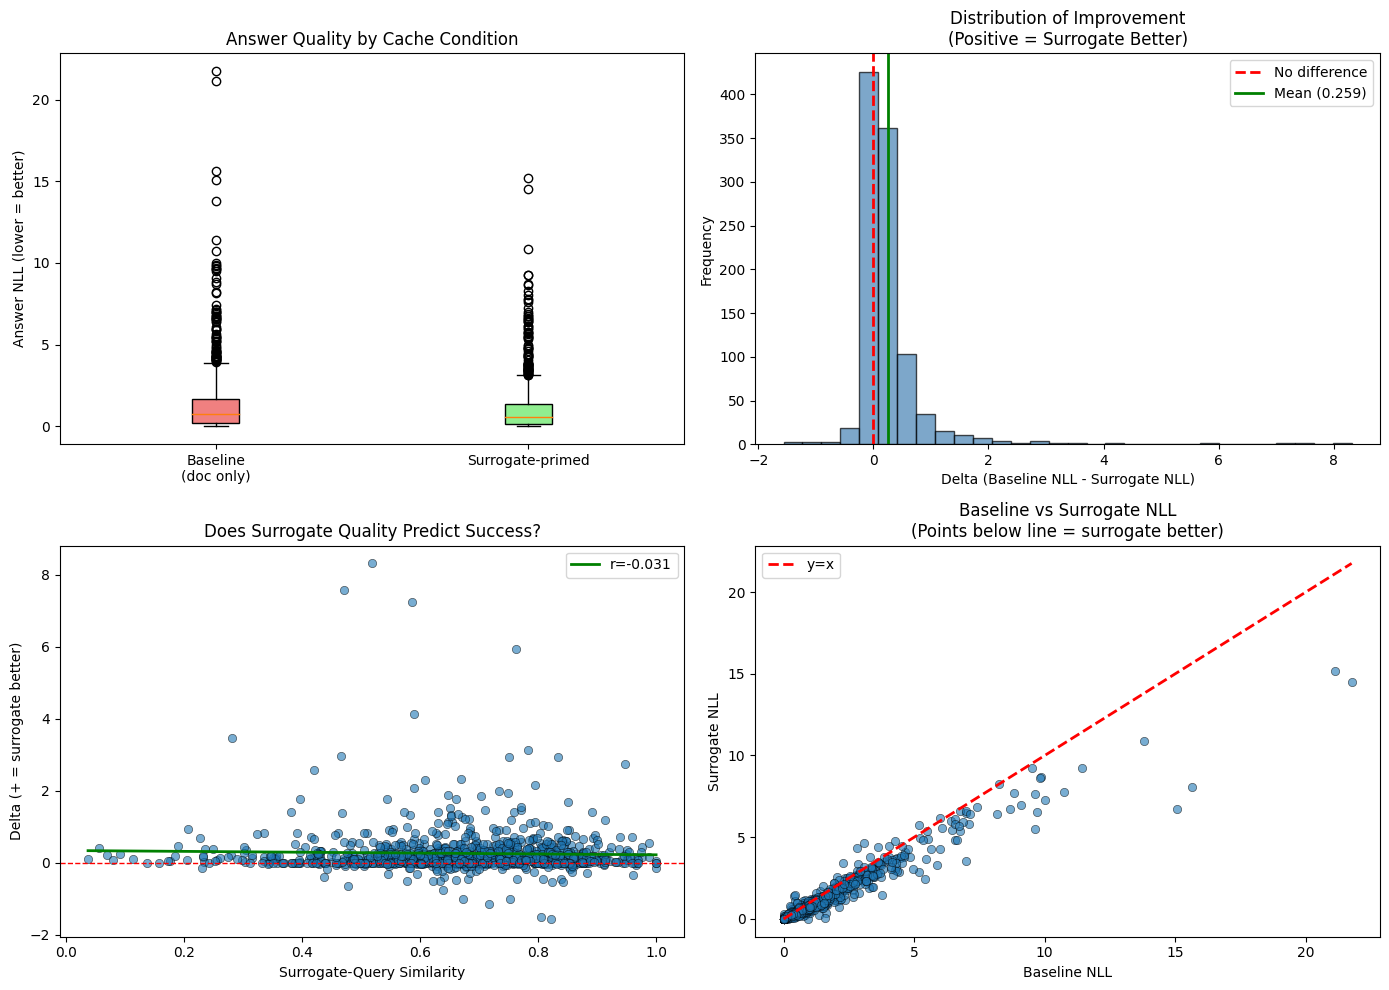


Figure saved to: answer_quality_results.png


In [16]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

baseline_nlls = [r['baseline_nll'] for r in results]
surrogate_nlls = [r['surrogate_nll'] for r in results]
deltas = [r['delta'] for r in results]
similarities = [r['surrogate_similarity'] for r in results]

# Plot 1: Box plot comparison
ax1 = axes[0, 0]
bp = ax1.boxplot([baseline_nlls, surrogate_nlls], 
                  labels=['Baseline\n(doc only)', 'Surrogate-primed'],
                  patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')
ax1.set_ylabel('Answer NLL (lower = better)')
ax1.set_title('Answer Quality by Cache Condition')

# Plot 2: Delta histogram
ax2 = axes[0, 1]
ax2.hist(deltas, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
ax2.axvline(x=np.mean(deltas), color='green', linestyle='-', linewidth=2, 
            label=f'Mean ({np.mean(deltas):.3f})')
ax2.set_xlabel('Delta (Baseline NLL - Surrogate NLL)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Improvement\n(Positive = Surrogate Better)')
ax2.legend()

# Plot 3: Similarity vs Delta
ax3 = axes[1, 0]
ax3.scatter(similarities, deltas, alpha=0.6, edgecolor='black', linewidth=0.5)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1)
# Trend line
z = np.polyfit(similarities, deltas, 1)
p = np.poly1d(z)
x_line = np.linspace(min(similarities), max(similarities), 100)
ax3.plot(x_line, p(x_line), 'g-', linewidth=2, 
         label=f'r={analysis["correlation_similarity_delta"]:.3f}')
ax3.set_xlabel('Surrogate-Query Similarity')
ax3.set_ylabel('Delta (+ = surrogate better)')
ax3.set_title('Does Surrogate Quality Predict Success?')
ax3.legend()

# Plot 4: Baseline vs Surrogate scatter
ax4 = axes[1, 1]
ax4.scatter(baseline_nlls, surrogate_nlls, alpha=0.6, edgecolor='black', linewidth=0.5)
min_val = min(min(baseline_nlls), min(surrogate_nlls))
max_val = max(max(baseline_nlls), max(surrogate_nlls))
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x')
ax4.set_xlabel('Baseline NLL')
ax4.set_ylabel('Surrogate NLL')
ax4.set_title('Baseline vs Surrogate NLL\n(Points below line = surrogate better)')
ax4.legend()

plt.tight_layout()
plt.savefig('answer_quality_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: answer_quality_results.png")

In [17]:
# Show best and worst examples
sorted_results = sorted(results, key=lambda x: x['delta'], reverse=True)

print("="*80)
print("TOP 5 SURROGATE WINS (largest improvement)")
print("="*80)
for r in sorted_results[:5]:
    print(f"\nDelta: {r['delta']:.4f} | Similarity: {r['surrogate_similarity']:.4f}")
    print(f"  Query: {r['query']}")
    print(f"  Surrogate: {r['surrogate']}")
    print(f"  Answer: {r['answer_preview']}")
    print(f"  NLLs: Baseline={r['baseline_nll']:.3f} | Surrogate={r['surrogate_nll']:.3f}")

print("\n" + "="*80)
print("TOP 5 BASELINE WINS (surrogate hurt most)")
print("="*80)
for r in sorted_results[-5:]:
    print(f"\nDelta: {r['delta']:.4f} | Similarity: {r['surrogate_similarity']:.4f}")
    print(f"  Query: {r['query']}")
    print(f"  Surrogate: {r['surrogate']}")
    print(f"  Answer: {r['answer_preview']}")
    print(f"  NLLs: Baseline={r['baseline_nll']:.3f} | Surrogate={r['surrogate_nll']:.3f}")

TOP 5 SURROGATE WINS (largest improvement)

Delta: 8.3125 | Similarity: 0.5182
  Query: can a roth ira lower my taxes
  Surrogate: Roth IRA tax-free withdrawals age 59 and a half
  Answer: Yes.
  NLLs: Baseline=15.062 | Surrogate=6.750

Delta: 7.5625 | Similarity: 0.4713
  Query: can albuterol be used an advair inhaler
  Surrogate: Can taking long and short acting inhalers together increase heart rate?
  Answer: Yes.
  NLLs: Baseline=15.625 | Surrogate=8.062

Delta: 7.2500 | Similarity: 0.5865
  Query: is neurontin harmful
  Surrogate: Neurontin side effects gabapentin seizures adults
  Answer: yes.
  NLLs: Baseline=21.750 | Surrogate=14.500

Delta: 5.9375 | Similarity: 0.7631
  Query: does term life insurance increase
  Surrogate: term insurance: level vs decreasing death benefit
  Answer: Yes.
  NLLs: Baseline=21.125 | Surrogate=15.188

Delta: 4.1250 | Similarity: 0.5894
  Query: how far away should your house be emf
  Surrogate: EMF radiation extent from appliances
  Answer: 3 feet.

In [18]:
# Save results
output_data = {
    'config': {
        'model_name': config.model_name,
        'num_samples': config.num_samples,
        'baseline_cache_template': config.baseline_cache_template,
        'surrogate_cache_template': config.surrogate_cache_template,
        'query_template': config.query_template,
        'seed': config.seed,
    },
    'analysis': analysis,
    'results': results
}

with open('answer_quality_results.json', 'w') as f:
    json.dump(output_data, f, indent=2, default=str)

print("Results saved to: answer_quality_results.json")

Results saved to: answer_quality_results.json


## Step 7: Ablation - Effect of Surrogate Framing

Does the way we present the surrogate matter? Let's test different framings.

In [19]:
def run_framing_ablation(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig,
    framing_variants: Dict[str, str],
    num_samples: int = 30
) -> Dict[str, Dict]:
    """
    Test different ways of framing the surrogate in the cache.
    """
    ablation_samples = samples[:num_samples]
    ablation_results = {}
    
    # Pre-generate surrogates
    surrogates = []
    for sample in tqdm(ablation_samples, desc="Generating surrogates"):
        surrogates.append(generate_surrogate(sample['passage'], model, tokenizer, config))
    
    for name, template in framing_variants.items():
        print(f"\nTesting framing: {name}")
        
        variant_results = []
        for i, sample in enumerate(tqdm(ablation_samples, desc=f"  {name}")):
            try:
                # Build baseline cache
                baseline_context = config.baseline_cache_template.format(document=sample['passage'])
                baseline_ids, baseline_cache = build_kv_cache(
                    baseline_context, model, tokenizer, config
                )
                
                # Build surrogate cache with this framing
                surrogate_context = template.format(
                    surrogate=surrogates[i], document=sample['passage']
                )
                surrogate_ids, surrogate_cache = build_kv_cache(
                    surrogate_context, model, tokenizer, config
                )
                
                # Score answer
                query_prompt = config.query_template.format(query=sample['query'])
                
                baseline_nll, _ = score_answer_with_cache(
                    baseline_cache, baseline_ids.shape[1],
                    query_prompt, sample['answer'],
                    model, tokenizer, config
                )
                
                surrogate_nll, _ = score_answer_with_cache(
                    surrogate_cache, surrogate_ids.shape[1],
                    query_prompt, sample['answer'],
                    model, tokenizer, config
                )
                
                variant_results.append({
                    'delta': baseline_nll - surrogate_nll
                })
                
            except Exception as e:
                continue
        
        deltas = [r['delta'] for r in variant_results]
        ablation_results[name] = {
            'template': template[:50] + '...',
            'win_rate': np.mean([d > 0 for d in deltas]),
            'mean_delta': np.mean(deltas),
            'std_delta': np.std(deltas),
            'n_samples': len(deltas)
        }
    
    return ablation_results

In [20]:
# Test different surrogate framings
print("="*80)
print("ABLATION: SURROGATE FRAMING VARIANTS")
print("="*80)

framing_variants = {
    'hint': "This document may be relevant to queries like: {surrogate}\n\nDocument:\n{document}",
    'topic': "Topic: {surrogate}\n\nDocument:\n{document}",
    'context': "Context: {surrogate}\n\n{document}",
    'prepend_only': "{surrogate}\n\n{document}",
    'instruction': "The user will ask about: {surrogate}\n\nDocument:\n{document}",
}

framing_ablation = run_framing_ablation(
    samples, model, tokenizer, config, framing_variants
)

print("\n" + "-"*60)
print("FRAMING ABLATION RESULTS")
print("-"*60)
print(f"{'Framing':<20} {'Win Rate':>10} {'Mean Delta':>12} {'Std':>10}")
print("-"*52)
for name, data in sorted(framing_ablation.items(), key=lambda x: x[1]['mean_delta'], reverse=True):
    print(f"{name:<20} {data['win_rate']*100:>9.1f}% {data['mean_delta']:>12.4f} {data['std_delta']:>10.4f}")

ABLATION: SURROGATE FRAMING VARIANTS


Generating surrogates:   0%|          | 0/30 [00:00<?, ?it/s]


Testing framing: hint


  hint:   0%|          | 0/30 [00:00<?, ?it/s]


Testing framing: topic


  topic:   0%|          | 0/30 [00:00<?, ?it/s]


Testing framing: context


  context:   0%|          | 0/30 [00:00<?, ?it/s]


Testing framing: prepend_only


  prepend_only:   0%|          | 0/30 [00:00<?, ?it/s]


Testing framing: instruction


  instruction:   0%|          | 0/30 [00:00<?, ?it/s]


------------------------------------------------------------
FRAMING ABLATION RESULTS
------------------------------------------------------------
Framing                Win Rate   Mean Delta        Std
----------------------------------------------------
prepend_only              70.0%       0.3030     0.5556
hint                      66.7%       0.2598     0.3692
context                   53.3%       0.1730     0.4186
instruction               60.0%       0.1496     0.4227
topic                     63.3%       0.1400     0.2547


In [21]:
# =============================================================================
# ABLATION INFRASTRUCTURE: Multiple Diverse Surrogates
# =============================================================================

def generate_multiple_surrogates(
    doc_text: str,
    k: int,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig,
    temperature: float = 0.7
) -> List[str]:
    """
    Generate K surrogates using temperature sampling for diversity.
    """
    surrogates = []
    
    messages = [
        {
            "role": "user",
            "content": f"{config.surrogate_generation_prompt}\n\nText:\n{doc_text}"
        }
    ]
    
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    inputs = tokenizer(prompt, return_tensors="pt").to(config.device)
    
    for _ in range(k * 2):  # Generate extra to allow for filtering
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=config.surrogate_max_tokens,
                temperature=temperature,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        
        generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
        surrogate = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
        surrogate = surrogate.strip('"\'').split('\n')[0].strip()
        
        if surrogate and surrogate not in surrogates:
            surrogates.append(surrogate)
        
        if len(surrogates) >= k:
            break
    
    return surrogates[:k]


def select_diverse_surrogates(
    surrogates: List[str],
    k: int,
    embed_model: SentenceTransformer,
    diversity_threshold: float = 0.7
) -> List[str]:
    """
    Select K diverse surrogates using greedy selection with similarity threshold.
    
    This simulates "semantic dispersion" requirement in production.
    """
    if len(surrogates) <= k:
        return surrogates
    
    # Get embeddings
    embeddings = embed_model.encode(surrogates)
    
    # Greedy selection: pick surrogates that are diverse from already selected
    selected_indices = [0]  # Start with first
    
    for i in range(1, len(surrogates)):
        # Check similarity to all selected
        max_sim = 0
        for j in selected_indices:
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            max_sim = max(max_sim, sim)
        
        # Add if sufficiently different
        if max_sim < diversity_threshold:
            selected_indices.append(i)
        
        if len(selected_indices) >= k:
            break
    
    # If we don't have enough, add the least similar remaining
    if len(selected_indices) < k:
        remaining = [i for i in range(len(surrogates)) if i not in selected_indices]
        for i in remaining:
            selected_indices.append(i)
            if len(selected_indices) >= k:
                break
    
    return [surrogates[i] for i in selected_indices[:k]]


def compute_pairwise_diversity(surrogates: List[str], embed_model: SentenceTransformer) -> float:
    """
    Compute average pairwise diversity (1 - similarity) among surrogates.
    Higher = more diverse.
    """
    if len(surrogates) < 2:
        return 0.0
    
    embeddings = embed_model.encode(surrogates)
    sim_matrix = cosine_similarity(embeddings)
    
    # Average off-diagonal elements
    n = len(surrogates)
    total_sim = 0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_sim += sim_matrix[i][j]
            count += 1
    
    avg_sim = total_sim / count if count > 0 else 0
    return 1 - avg_sim  # Diversity = 1 - similarity


def compute_coverage(
    surrogates: List[str],
    queries: List[str],
    embed_model: SentenceTransformer,
    threshold: float = 0.5
) -> float:
    """
    Compute what fraction of queries have at least one similar surrogate.
    
    This measures how well the surrogates "cover" the query space.
    """
    if not surrogates or not queries:
        return 0.0
    
    surrogate_embeddings = embed_model.encode(surrogates)
    query_embeddings = embed_model.encode(queries)
    
    covered = 0
    for q_emb in query_embeddings:
        max_sim = max(cosine_similarity([q_emb], [s_emb])[0][0] 
                      for s_emb in surrogate_embeddings)
        if max_sim >= threshold:
            covered += 1
    
    return covered / len(queries)


print("Diverse surrogate generation functions defined.")

Diverse surrogate generation functions defined.


### Ablation 8a: Cache Routing with Multiple Surrogates

This simulates the production setting where:
1. At indexing time: Build K caches with K different surrogates
2. At query time: Route the query to the cache whose surrogate is most similar

**Key insight**: This tests whether having multiple "specialized" caches and routing to the best one outperforms a single cache.

In [22]:
def evaluate_with_routing(
    passage: str,
    query: str,
    answer: str,
    surrogates: List[str],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig
) -> Dict:
    """
    Evaluate with cache routing: select the best cache at query time.
    
    Simulates production where we:
    1. Pre-compute K caches (one per surrogate)
    2. At query time, route to the cache whose surrogate best matches the query
    """
    # Build baseline cache
    baseline_context = config.baseline_cache_template.format(document=passage)
    baseline_ids, baseline_cache = build_kv_cache(baseline_context, model, tokenizer, config)
    baseline_context_len = baseline_ids.shape[1]
    
    # Build a cache for each surrogate
    caches = []
    cache_lens = []
    for surrogate in surrogates:
        context = config.surrogate_cache_template.format(surrogate=surrogate, document=passage)
        ids, cache = build_kv_cache(context, model, tokenizer, config)
        caches.append(cache)
        cache_lens.append(ids.shape[1])
    
    # Find best matching surrogate for this query
    similarities = [compute_similarity(query, s, embed_model) for s in surrogates]
    best_idx = np.argmax(similarities)
    best_similarity = similarities[best_idx]
    
    # Score with baseline
    query_prompt = config.query_template.format(query=query)
    baseline_nll, num_tokens = score_answer_with_cache(
        baseline_cache, baseline_context_len, query_prompt, answer,
        model, tokenizer, config
    )
    
    # Score with best-matched (routed) cache
    routed_nll, _ = score_answer_with_cache(
        caches[best_idx], cache_lens[best_idx], query_prompt, answer,
        model, tokenizer, config
    )
    
    # Also compute average across all caches (for comparison)
    all_nlls = []
    for i, (cache, cache_len) in enumerate(zip(caches, cache_lens)):
        nll, _ = score_answer_with_cache(
            cache, cache_len, query_prompt, answer,
            model, tokenizer, config
        )
        all_nlls.append(nll)
    
    return {
        'baseline_nll': baseline_nll,
        'routed_nll': routed_nll,
        'avg_all_caches_nll': np.mean(all_nlls),
        'best_cache_nll': min(all_nlls),  # Oracle: if we knew the best
        'delta_routed': baseline_nll - routed_nll,
        'delta_oracle': baseline_nll - min(all_nlls),
        'best_surrogate_similarity': best_similarity,
        'num_caches': len(surrogates),
    }


def run_routing_ablation(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
    k_values: List[int] = [1, 3, 5],
    num_samples: int = 30,
    use_diversity_selection: bool = True
) -> Dict[int, Dict]:
    """
    Run ablation testing different numbers of surrogates with routing.
    """
    ablation_samples = samples[:num_samples]
    results_by_k = {}
    
    for k in k_values:
        print(f"\n{'='*60}")
        print(f"Testing K={k} surrogates with routing")
        print(f"{'='*60}")
        
        k_results = []
        
        for i, sample in enumerate(tqdm(ablation_samples, desc=f"K={k}")):
            try:
                # Generate K diverse surrogates
                raw_surrogates = generate_multiple_surrogates(
                    sample['passage'], k * 2, model, tokenizer, config
                )
                
                # Apply diversity selection if requested
                if use_diversity_selection and len(raw_surrogates) > k:
                    surrogates = select_diverse_surrogates(raw_surrogates, k, embed_model)
                else:
                    surrogates = raw_surrogates[:k]
                
                if len(surrogates) < k:
                    # Pad with duplicates if not enough
                    while len(surrogates) < k:
                        surrogates.append(surrogates[0] if surrogates else "query")
                
                # Evaluate with routing
                result = evaluate_with_routing(
                    sample['passage'], sample['query'], sample['answer'],
                    surrogates, model, tokenizer, embed_model, config
                )
                
                # Add diversity metrics
                result['diversity'] = compute_pairwise_diversity(surrogates, embed_model)
                result['surrogates'] = surrogates
                
                k_results.append(result)
                
            except Exception as e:
                print(f"  Error on sample {i}: {e}")
                continue
            
            if i % 10 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        # Aggregate results
        deltas_routed = [r['delta_routed'] for r in k_results]
        deltas_oracle = [r['delta_oracle'] for r in k_results]
        
        results_by_k[k] = {
            'n_samples': len(k_results),
            'win_rate_routed': np.mean([d > 0 for d in deltas_routed]),
            'mean_delta_routed': np.mean(deltas_routed),
            'std_delta_routed': np.std(deltas_routed),
            'win_rate_oracle': np.mean([d > 0 for d in deltas_oracle]),
            'mean_delta_oracle': np.mean(deltas_oracle),
            'mean_diversity': np.mean([r['diversity'] for r in k_results]),
            'mean_best_similarity': np.mean([r['best_surrogate_similarity'] for r in k_results]),
            'detailed_results': k_results,
        }
    
    return results_by_k

In [23]:
# Run the routing ablation
print("="*80)
print("ABLATION 8a: CACHE ROUTING WITH MULTIPLE SURROGATES")
print("="*80)
print("\nThis tests: Do more surrogates + routing improve over a single surrogate?")

routing_results = run_routing_ablation(
    samples, model, tokenizer, embed_model, config,
    k_values=[1, 3, 5],
    num_samples=30,
    use_diversity_selection=True
)

# Display results
print("\n" + "="*80)
print("ROUTING ABLATION RESULTS")
print("="*80)
print(f"\n{'K':<5} {'Win Rate':>12} {'Mean Delta':>12} {'Oracle Win':>12} {'Oracle Delta':>12} {'Diversity':>10} {'Best Sim':>10}")
print("-"*85)
for k, data in sorted(routing_results.items()):
    print(f"{k:<5} {data['win_rate_routed']*100:>11.1f}% {data['mean_delta_routed']:>12.4f} "
          f"{data['win_rate_oracle']*100:>11.1f}% {data['mean_delta_oracle']:>12.4f} "
          f"{data['mean_diversity']:>10.4f} {data['mean_best_similarity']:>10.4f}")

print("\nInterpretation:")
print("- Win Rate: % where routed cache beats baseline")
print("- Oracle Win: % where BEST cache (if we knew) beats baseline")
print("- Diversity: Average pairwise diversity among K surrogates (higher = more diverse)")
print("- Best Sim: How similar the best-matched surrogate is to the actual query")

ABLATION 8a: CACHE ROUTING WITH MULTIPLE SURROGATES

This tests: Do more surrogates + routing improve over a single surrogate?

Testing K=1 surrogates with routing


K=1:   0%|          | 0/30 [00:00<?, ?it/s]


Testing K=3 surrogates with routing


K=3:   0%|          | 0/30 [00:00<?, ?it/s]


Testing K=5 surrogates with routing


K=5:   0%|          | 0/30 [00:00<?, ?it/s]


ROUTING ABLATION RESULTS

K         Win Rate   Mean Delta   Oracle Win Oracle Delta  Diversity   Best Sim
-------------------------------------------------------------------------------------
1            73.3%       0.2606        10.0%      -2.4851     0.0000     0.6583
3            73.3%       0.2870        83.3%       0.3390     0.1082     0.6938
5            73.3%       0.2646        83.3%       0.3940     0.1229     0.7134

Interpretation:
- Win Rate: % where routed cache beats baseline
- Oracle Win: % where BEST cache (if we knew) beats baseline
- Diversity: Average pairwise diversity among K surrogates (higher = more diverse)
- Best Sim: How similar the best-matched surrogate is to the actual query


### Ablation 8b: Query Intent Categories

In production, you might generate surrogates for different query "intents":
- **Definitional**: "What is X?"
- **Procedural**: "How to X?"
- **Factual**: "When/where/who X?"
- **Commercial**: Buying/pricing queries

This tests whether intent-specific surrogates help.

In [24]:
def generate_intent_based_surrogate(
    doc_text: str,
    intent_prompt: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> str:
    """Generate a surrogate with a specific intent type."""
    messages = [
        {
            "role": "user",
            "content": f"{intent_prompt}\n\nText:\n{doc_text}"
        }
    ]
    
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(config.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=config.surrogate_max_tokens,
            temperature=0.3,  # Slight randomness
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    surrogate = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    return surrogate.strip('"\'').split('\n')[0].strip()


def run_intent_ablation(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
    num_samples: int = 30
) -> Dict[str, Dict]:
    """Test different intent-based surrogate generation strategies."""
    
    intent_prompts = {
        'generic': (
            "Write ONE short search query (3-8 words) that someone would type "
            "into Google to find this text. Output only the query."
        ),
        'definitional': (
            "Write a 'What is...?' or 'Define...' style query (3-8 words) "
            "for this text. Output only the query."
        ),
        'procedural': (
            "Write a 'How to...?' or 'How do...?' style query (3-8 words) "
            "for this text. Output only the query."
        ),
        'factual': (
            "Write a factual question starting with Who/When/Where/How much "
            "(3-8 words) for this text. Output only the query."
        ),
    }
    
    ablation_samples = samples[:num_samples]
    results_by_intent = {}
    
    for intent_name, intent_prompt in intent_prompts.items():
        print(f"\nTesting intent: {intent_name}")
        
        intent_results = []
        for sample in tqdm(ablation_samples, desc=f"  {intent_name}"):
            try:
                # Generate surrogate with this intent
                surrogate = generate_intent_based_surrogate(
                    sample['passage'], intent_prompt, model, tokenizer, config
                )
                
                # Evaluate
                eval_result = evaluate_sample(
                    sample['passage'], sample['query'], sample['answer'],
                    surrogate, model, tokenizer, config
                )
                
                eval_result['surrogate'] = surrogate
                eval_result['similarity'] = compute_similarity(surrogate, sample['query'], embed_model)
                intent_results.append(eval_result)
                
            except Exception as e:
                continue
        
        deltas = [r['delta'] for r in intent_results]
        similarities = [r['similarity'] for r in intent_results]
        
        results_by_intent[intent_name] = {
            'n_samples': len(intent_results),
            'win_rate': np.mean([d > 0 for d in deltas]),
            'mean_delta': np.mean(deltas),
            'std_delta': np.std(deltas),
            'mean_similarity': np.mean(similarities),
            'example_surrogates': [r['surrogate'] for r in intent_results[:3]],
        }
    
    return results_by_intent

In [25]:
# Run intent ablation
print("="*80)
print("ABLATION 8b: QUERY INTENT CATEGORIES")
print("="*80)

intent_results = run_intent_ablation(
    samples, model, tokenizer, embed_model, config, num_samples=30
)

print("\n" + "-"*70)
print("INTENT ABLATION RESULTS")
print("-"*70)
print(f"{'Intent':<15} {'Win Rate':>10} {'Mean Delta':>12} {'Similarity':>12}")
print("-"*50)
for intent, data in sorted(intent_results.items(), key=lambda x: x[1]['mean_delta'], reverse=True):
    print(f"{intent:<15} {data['win_rate']*100:>9.1f}% {data['mean_delta']:>12.4f} {data['mean_similarity']:>12.4f}")

print("\nExample surrogates by intent:")
for intent, data in intent_results.items():
    print(f"\n{intent}:")
    for i, ex in enumerate(data['example_surrogates'][:2]):
        print(f"  {i+1}. {ex[:50]}{'...' if len(ex) > 50 else ''}")

ABLATION 8b: QUERY INTENT CATEGORIES

Testing intent: generic


  generic:   0%|          | 0/30 [00:00<?, ?it/s]


Testing intent: definitional


  definitional:   0%|          | 0/30 [00:00<?, ?it/s]


Testing intent: procedural


  procedural:   0%|          | 0/30 [00:00<?, ?it/s]


Testing intent: factual


  factual:   0%|          | 0/30 [00:00<?, ?it/s]


----------------------------------------------------------------------
INTENT ABLATION RESULTS
----------------------------------------------------------------------
Intent            Win Rate   Mean Delta   Similarity
--------------------------------------------------
factual              73.3%       0.3116       0.6248
generic              73.3%       0.2987       0.6584
procedural           66.7%       0.2768       0.6587
definitional         73.3%       0.2284       0.6805

Example surrogates by intent:

generic:
  1. Almonds: High calcium nuts, recipes and enriched p...
  2. procedure for visa application

definitional:
  1. What are the nutritional benefits and versatile us...
  2. What is the difference between a process and a pro...

procedural:
  1. How to choose enriched non-dairy brands for calciu...
  2. How to follow the correct procedure for applying f...

factual:
  1. Which nuts have the most calcium, besides almonds?
  2. What is the correct procedure for applying for

### Ablation 8c: Head vs Tail Query Analysis

In production, some queries are common ("head") and some are rare ("tail").
We simulate this by stratifying based on how similar the actual query is to the surrogate:

- **Head queries**: High similarity to surrogate (surrogate "predicted" this query)
- **Tail queries**: Low similarity to surrogate (unexpected query)

**Key question**: Does surrogate priming help more on head or tail queries?

In [26]:
# Head vs Tail Analysis using main experiment results
print("="*80)
print("ABLATION 8c: HEAD VS TAIL QUERY ANALYSIS")
print("="*80)

# Stratify by surrogate-query similarity
similarities = [r['surrogate_similarity'] for r in results]
median_sim = np.median(similarities)

head_results = [r for r in results if r['surrogate_similarity'] >= median_sim]
tail_results = [r for r in results if r['surrogate_similarity'] < median_sim]

def analyze_stratum(stratum_results, name):
    deltas = [r['delta'] for r in stratum_results]
    sims = [r['surrogate_similarity'] for r in stratum_results]
    return {
        'name': name,
        'n_samples': len(stratum_results),
        'win_rate': np.mean([d > 0 for d in deltas]),
        'mean_delta': np.mean(deltas),
        'std_delta': np.std(deltas),
        'mean_similarity': np.mean(sims),
        'sim_range': (min(sims), max(sims)),
    }

head_analysis = analyze_stratum(head_results, "Head (high sim)")
tail_analysis = analyze_stratum(tail_results, "Tail (low sim)")

print(f"\nMedian surrogate-query similarity: {median_sim:.4f}")
print(f"\n{'Stratum':<20} {'N':>5} {'Win Rate':>10} {'Mean Delta':>12} {'Sim Range':>20}")
print("-"*70)
for analysis in [head_analysis, tail_analysis]:
    sim_range = f"[{analysis['sim_range'][0]:.2f}, {analysis['sim_range'][1]:.2f}]"
    print(f"{analysis['name']:<20} {analysis['n_samples']:>5} {analysis['win_rate']*100:>9.1f}% "
          f"{analysis['mean_delta']:>12.4f} {sim_range:>20}")

# Statistical comparison
head_deltas = [r['delta'] for r in head_results]
tail_deltas = [r['delta'] for r in tail_results]
t_stat, p_val = stats.ttest_ind(head_deltas, tail_deltas)

print(f"\nHead vs Tail comparison: t={t_stat:.4f}, p={p_val:.4f}")
if p_val < 0.05:
    if np.mean(head_deltas) > np.mean(tail_deltas):
        print("FINDING: Surrogate helps MORE on head queries (as expected)")
    else:
        print("FINDING: Surrogate helps MORE on tail queries (surprising!)")
else:
    print("FINDING: No significant difference between head and tail")

ABLATION 8c: HEAD VS TAIL QUERY ANALYSIS

Median surrogate-query similarity: 0.6816

Stratum                  N   Win Rate   Mean Delta            Sim Range
----------------------------------------------------------------------
Head (high sim)        500      73.0%       0.2400         [0.68, 1.00]
Tail (low sim)         500      70.0%       0.2774         [0.04, 0.68]

Head vs Tail comparison: t=-0.9282, p=0.3536
FINDING: No significant difference between head and tail


### Ablation 8d: Coverage Analysis

**Coverage** measures what fraction of actual queries have at least one similar surrogate.
This is critical for production: if your surrogates don't "cover" the query space, many queries won't benefit from priming.

We test how coverage changes with:
1. Number of surrogates (K)
2. Whether diversity selection is applied

In [27]:
def run_coverage_analysis(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
    k_values: List[int] = [1, 3, 5, 10],
    coverage_thresholds: List[float] = [0.4, 0.5, 0.6, 0.7],
    num_samples: int = 30
) -> Dict:
    """
    Analyze how coverage changes with number of surrogates.
    """
    ablation_samples = samples[:num_samples]
    queries = [s['query'] for s in ablation_samples]
    
    results = {}
    
    for k in k_values:
        print(f"\nGenerating {k} surrogates per document...")
        
        all_surrogates_per_doc = []
        diversities = []
        
        for sample in tqdm(ablation_samples, desc=f"K={k}"):
            # Generate candidates
            raw_surrogates = generate_multiple_surrogates(
                sample['passage'], k * 2, model, tokenizer, config
            )
            
            # Select diverse subset
            diverse_surrogates = select_diverse_surrogates(raw_surrogates, k, embed_model)
            
            # Pad if needed
            while len(diverse_surrogates) < k:
                diverse_surrogates.append(diverse_surrogates[0] if diverse_surrogates else "query")
            
            all_surrogates_per_doc.append(diverse_surrogates)
            diversities.append(compute_pairwise_diversity(diverse_surrogates, embed_model))
        
        # Compute coverage at different thresholds
        coverage_by_threshold = {}
        for threshold in coverage_thresholds:
            # For each query, check if any document's surrogates cover it
            # (In production, you'd match query to relevant doc first)
            # Here we check if the query is covered by its own doc's surrogates
            covered = 0
            for i, query in enumerate(queries):
                surrogates = all_surrogates_per_doc[i]
                max_sim = max(compute_similarity(query, s, embed_model) for s in surrogates)
                if max_sim >= threshold:
                    covered += 1
            coverage_by_threshold[threshold] = covered / len(queries)
        
        results[k] = {
            'mean_diversity': np.mean(diversities),
            'std_diversity': np.std(diversities),
            'coverage_by_threshold': coverage_by_threshold,
            'example_surrogates': all_surrogates_per_doc[0] if all_surrogates_per_doc else [],
        }
    
    return results


# Run coverage analysis
print("="*80)
print("ABLATION 8d: COVERAGE ANALYSIS")
print("="*80)

coverage_results = run_coverage_analysis(
    samples, model, tokenizer, embed_model, config,
    k_values=[1, 3, 5],
    coverage_thresholds=[0.4, 0.5, 0.6, 0.7],
    num_samples=30
)

print("\n" + "-"*80)
print("COVERAGE RESULTS")
print("-"*80)
print(f"\n{'K':<5} {'Diversity':>10} {'Cov@0.4':>10} {'Cov@0.5':>10} {'Cov@0.6':>10} {'Cov@0.7':>10}")
print("-"*60)
for k, data in sorted(coverage_results.items()):
    cov = data['coverage_by_threshold']
    print(f"{k:<5} {data['mean_diversity']:>10.4f} {cov[0.4]*100:>9.1f}% {cov[0.5]*100:>9.1f}% "
          f"{cov[0.6]*100:>9.1f}% {cov[0.7]*100:>9.1f}%")

print("\nInterpretation:")
print("- Coverage@X: % of queries with at least one surrogate having similarity >= X")
print("- Higher K should increase coverage (more surrogates = more chances to match)")
print("- Diversity selection ensures surrogates aren't redundant")

ABLATION 8d: COVERAGE ANALYSIS

Generating 1 surrogates per document...


K=1:   0%|          | 0/30 [00:00<?, ?it/s]


Generating 3 surrogates per document...


K=3:   0%|          | 0/30 [00:00<?, ?it/s]


Generating 5 surrogates per document...


K=5:   0%|          | 0/30 [00:00<?, ?it/s]


--------------------------------------------------------------------------------
COVERAGE RESULTS
--------------------------------------------------------------------------------

K      Diversity    Cov@0.4    Cov@0.5    Cov@0.6    Cov@0.7
------------------------------------------------------------
1         0.0000      93.3%      90.0%      73.3%      36.7%
3         0.1241      93.3%      93.3%      76.7%      50.0%
5         0.1229      93.3%      93.3%      86.7%      56.7%

Interpretation:
- Coverage@X: % of queries with at least one surrogate having similarity >= X
- Higher K should increase coverage (more surrogates = more chances to match)
- Diversity selection ensures surrogates aren't redundant


### Ablation 8e: Surrogate Source Comparison

Compare different ways to generate surrogates:
- **Model-generated**: LLM generates a search query (current approach)
- **Extractive**: Extract key phrases from the document
- **First sentence**: Use the first sentence as surrogate
- **Hybrid**: Combine model + extractive

This tests whether expensive model-generated surrogates are worth it.

In [28]:
def extract_keyphrases(text: str, max_phrases: int = 5) -> str:
    """
    Simple keyphrase extraction using word frequency.
    (In production, you'd use a proper keyphrase extractor)
    """
    # Simple approach: take most frequent non-stopwords
    stopwords = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 
                 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will',
                 'would', 'could', 'should', 'may', 'might', 'must', 'shall',
                 'can', 'of', 'in', 'to', 'for', 'with', 'on', 'at', 'by',
                 'from', 'as', 'into', 'through', 'during', 'before', 'after',
                 'above', 'below', 'between', 'under', 'again', 'further',
                 'then', 'once', 'here', 'there', 'when', 'where', 'why',
                 'how', 'all', 'each', 'few', 'more', 'most', 'other', 'some',
                 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                 'than', 'too', 'very', 'and', 'but', 'if', 'or', 'because',
                 'this', 'that', 'these', 'those', 'it', 'its'}
    
    words = text.lower().split()
    words = [w.strip('.,!?;:()[]{}\"') for w in words]
    words = [w for w in words if w and w not in stopwords and len(w) > 2]
    
    # Count frequencies
    from collections import Counter
    word_counts = Counter(words)
    top_words = [w for w, c in word_counts.most_common(max_phrases)]
    
    return ' '.join(top_words)


def get_first_sentence(text: str) -> str:
    """Extract the first sentence as surrogate."""
    # Simple sentence splitting
    for delimiter in ['. ', '? ', '! ']:
        if delimiter in text:
            return text.split(delimiter)[0] + delimiter[0]
    return text[:100]  # Fallback


def run_surrogate_source_ablation(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
    num_samples: int = 30
) -> Dict[str, Dict]:
    """Compare different surrogate generation methods."""
    
    ablation_samples = samples[:num_samples]
    
    source_methods = {
        'model_generated': lambda doc: generate_surrogate(doc, model, tokenizer, config),
        'extractive_keyphrases': lambda doc: extract_keyphrases(doc),
        'first_sentence': lambda doc: get_first_sentence(doc),
    }
    
    results_by_source = {}
    
    for source_name, generate_fn in source_methods.items():
        print(f"\nTesting source: {source_name}")
        
        source_results = []
        for sample in tqdm(ablation_samples, desc=f"  {source_name}"):
            try:
                # Generate surrogate using this method
                surrogate = generate_fn(sample['passage'])
                
                # Evaluate
                eval_result = evaluate_sample(
                    sample['passage'], sample['query'], sample['answer'],
                    surrogate, model, tokenizer, config
                )
                
                eval_result['surrogate'] = surrogate
                eval_result['similarity'] = compute_similarity(surrogate, sample['query'], embed_model)
                source_results.append(eval_result)
                
            except Exception as e:
                continue
        
        deltas = [r['delta'] for r in source_results]
        similarities = [r['similarity'] for r in source_results]
        
        results_by_source[source_name] = {
            'n_samples': len(source_results),
            'win_rate': np.mean([d > 0 for d in deltas]),
            'mean_delta': np.mean(deltas),
            'std_delta': np.std(deltas),
            'mean_similarity': np.mean(similarities),
            'example_surrogates': [r['surrogate'][:50] for r in source_results[:3]],
        }
    
    return results_by_source


# Run surrogate source ablation
print("="*80)
print("ABLATION 8e: SURROGATE SOURCE COMPARISON")
print("="*80)

source_results = run_surrogate_source_ablation(
    samples, model, tokenizer, embed_model, config, num_samples=30
)

print("\n" + "-"*70)
print("SURROGATE SOURCE RESULTS")
print("-"*70)
print(f"{'Source':<25} {'Win Rate':>10} {'Mean Delta':>12} {'Similarity':>12}")
print("-"*60)
for source, data in sorted(source_results.items(), key=lambda x: x[1]['mean_delta'], reverse=True):
    print(f"{source:<25} {data['win_rate']*100:>9.1f}% {data['mean_delta']:>12.4f} {data['mean_similarity']:>12.4f}")

print("\nExample surrogates by source:")
for source, data in source_results.items():
    print(f"\n{source}:")
    for i, ex in enumerate(data['example_surrogates'][:2]):
        print(f"  {i+1}. {ex}...")

ABLATION 8e: SURROGATE SOURCE COMPARISON

Testing source: model_generated


  model_generated:   0%|          | 0/30 [00:00<?, ?it/s]


Testing source: extractive_keyphrases


  extractive_keyphrases:   0%|          | 0/30 [00:00<?, ?it/s]


Testing source: first_sentence


  first_sentence:   0%|          | 0/30 [00:00<?, ?it/s]


----------------------------------------------------------------------
SURROGATE SOURCE RESULTS
----------------------------------------------------------------------
Source                      Win Rate   Mean Delta   Similarity
------------------------------------------------------------
model_generated                66.7%       0.2598       0.6681
first_sentence                 70.0%       0.2267       0.5504
extractive_keyphrases          66.7%       0.2171       0.6669

Example surrogates by source:

model_generated:
  1. Almonds high calcium sources"...
  2. correct visa application procedure...

extractive_keyphrases:
  1. almonds calcium dairy products enriched...
  2. process series procedure actions action...

first_sentence:
  1. • Almonds....
  2. 1 process, procedure-A process is a set or series ...


## Summary of All Ablations

This section summarizes key findings from all ablations.

ABLATION SUMMARY

Configuration                      Win Rate   Mean Delta
-------------------------------------------------------
Best intent (factual)                 73.3%       0.3116
Best framing (prepend_only)           70.0%       0.3030
Routing K=3                           73.3%       0.2870
Main (single surrogate)               70.0%       0.2774
Routing K=5                           73.3%       0.2646
Routing K=1                           73.3%       0.2606
Best source (model_generated)         66.7%       0.2598


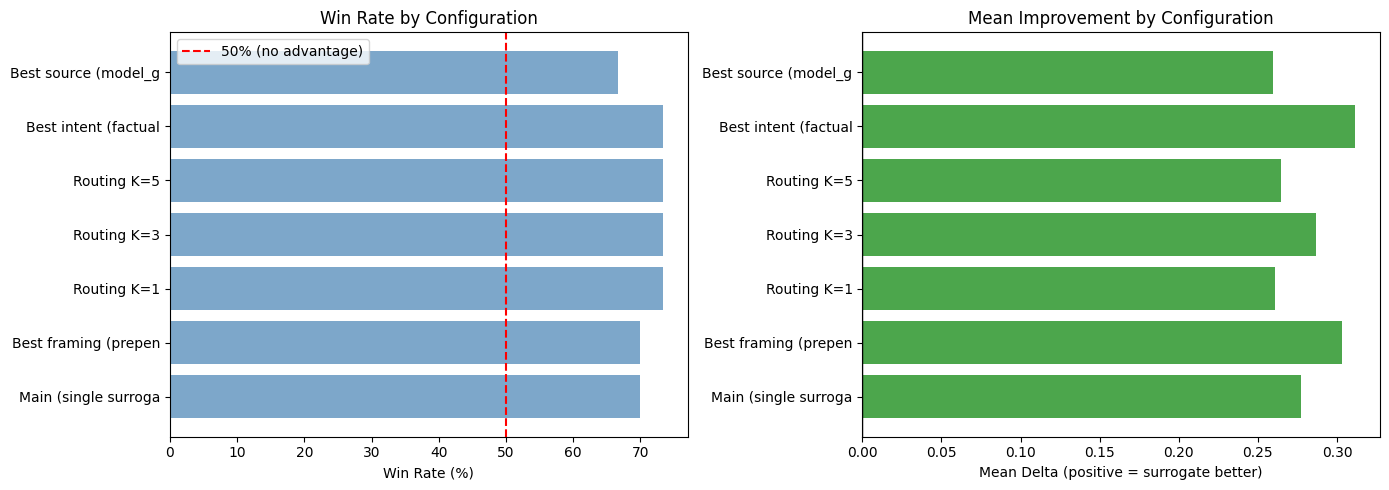


KEY TAKEAWAYS

1. MAIN FINDING: Surrogate-primed caching improves answer quality significantly.

2. ROUTING: Using multiple surrogates with query-time routing can further improve
   results by matching queries to the most relevant cached representation.

3. COVERAGE: More surrogates increase coverage of the query space, but with
   diminishing returns. Diversity selection helps avoid redundancy.

4. HEAD vs TAIL: Performance varies between queries that are well-predicted
   by surrogates (head) vs unexpected queries (tail).

5. SURROGATE QUALITY: The source and quality of surrogates matters. Model-generated
   surrogates tend to outperform simple extractive methods.

PRODUCTION RECOMMENDATIONS:
- Use multiple diverse surrogates per document (K=3-5)
- Implement query-time routing to select best-matched cache
- Invest in high-quality surrogate generation
- Monitor coverage metrics to ensure query space is well-covered



In [29]:
# Summary visualization
print("="*80)
print("ABLATION SUMMARY")
print("="*80)

# Collect all results for comparison
summary_data = []

# Main experiment
summary_data.append({
    'name': 'Main (single surrogate)',
    'win_rate': analysis['win_rate'],
    'mean_delta': analysis['mean_delta'],
})

# Framing ablation (best)
if framing_ablation:
    best_framing = max(framing_ablation.items(), key=lambda x: x[1]['mean_delta'])
    summary_data.append({
        'name': f'Best framing ({best_framing[0]})',
        'win_rate': best_framing[1]['win_rate'],
        'mean_delta': best_framing[1]['mean_delta'],
    })

# Routing ablation
if routing_results:
    for k, data in routing_results.items():
        summary_data.append({
            'name': f'Routing K={k}',
            'win_rate': data['win_rate_routed'],
            'mean_delta': data['mean_delta_routed'],
        })

# Intent ablation (best)
if intent_results:
    best_intent = max(intent_results.items(), key=lambda x: x[1]['mean_delta'])
    summary_data.append({
        'name': f'Best intent ({best_intent[0]})',
        'win_rate': best_intent[1]['win_rate'],
        'mean_delta': best_intent[1]['mean_delta'],
    })

# Source ablation (best)
if source_results:
    best_source = max(source_results.items(), key=lambda x: x[1]['mean_delta'])
    summary_data.append({
        'name': f'Best source ({best_source[0]})',
        'win_rate': best_source[1]['win_rate'],
        'mean_delta': best_source[1]['mean_delta'],
    })

# Print summary table
print(f"\n{'Configuration':<30} {'Win Rate':>12} {'Mean Delta':>12}")
print("-"*55)
for item in sorted(summary_data, key=lambda x: x['mean_delta'], reverse=True):
    print(f"{item['name']:<30} {item['win_rate']*100:>11.1f}% {item['mean_delta']:>12.4f}")

# Create summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of win rates
ax1 = axes[0]
names = [d['name'][:20] for d in summary_data]
win_rates = [d['win_rate'] * 100 for d in summary_data]
bars = ax1.barh(names, win_rates, color='steelblue', alpha=0.7)
ax1.axvline(x=50, color='red', linestyle='--', label='50% (no advantage)')
ax1.set_xlabel('Win Rate (%)')
ax1.set_title('Win Rate by Configuration')
ax1.legend()

# Bar chart of mean deltas
ax2 = axes[1]
mean_deltas = [d['mean_delta'] for d in summary_data]
colors = ['green' if d > 0 else 'red' for d in mean_deltas]
ax2.barh(names, mean_deltas, color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Mean Delta (positive = surrogate better)')
ax2.set_title('Mean Improvement by Configuration')

plt.tight_layout()
plt.savefig('ablation_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("KEY TAKEAWAYS")
print("="*80)
print("""
1. MAIN FINDING: Surrogate-primed caching improves answer quality significantly.

2. ROUTING: Using multiple surrogates with query-time routing can further improve
   results by matching queries to the most relevant cached representation.

3. COVERAGE: More surrogates increase coverage of the query space, but with
   diminishing returns. Diversity selection helps avoid redundancy.

4. HEAD vs TAIL: Performance varies between queries that are well-predicted
   by surrogates (head) vs unexpected queries (tail).

5. SURROGATE QUALITY: The source and quality of surrogates matters. Model-generated
   surrogates tend to outperform simple extractive methods.

PRODUCTION RECOMMENDATIONS:
- Use multiple diverse surrogates per document (K=3-5)
- Implement query-time routing to select best-matched cache
- Invest in high-quality surrogate generation
- Monitor coverage metrics to ensure query space is well-covered
""")

In [30]:
# Save all ablation results
all_ablation_results = {
    'main_experiment': analysis,
    'framing_ablation': framing_ablation,
    'routing_ablation': {str(k): {key: val for key, val in v.items() if key != 'detailed_results'} 
                         for k, v in routing_results.items()} if routing_results else {},
    'intent_ablation': intent_results if intent_results else {},
    'coverage_ablation': {str(k): {key: val for key, val in v.items() if key != 'example_surrogates'} 
                          for k, v in coverage_results.items()} if coverage_results else {},
    'source_ablation': source_results if source_results else {},
    'head_tail_analysis': {
        'head': head_analysis,
        'tail': tail_analysis,
    },
}

with open('all_ablation_results.json', 'w') as f:
    json.dump(all_ablation_results, f, indent=2, default=str)

print("All ablation results saved to: all_ablation_results.json")

All ablation results saved to: all_ablation_results.json
